In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, make_scorer

In [15]:
data = pd.read_csv('creditcard.csv')  
print(data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [16]:
date_columns = []
for col in data.columns:
    try:
        pd.to_datetime(data[col])
        date_columns.append(col)
    except (ValueError, TypeError):
        continue

print("Possible date columns:", date_columns)


Possible date columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [17]:
scaler = StandardScaler()
data['scaled_amount'] = scaler.fit_transform(data[['Amount']])
data['scaled_time'] = scaler.fit_transform(data[['Time']])

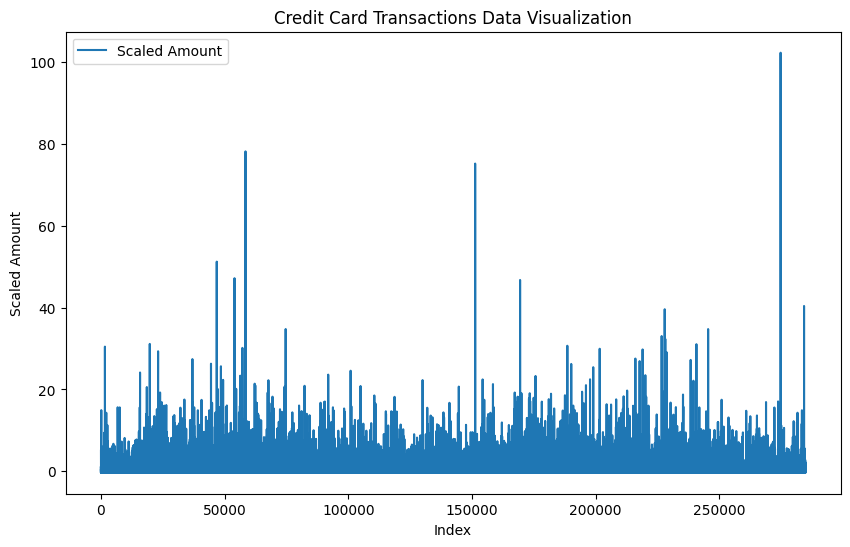

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['scaled_amount'], label='Scaled Amount')
plt.title('Credit Card Transactions Data Visualization')
plt.xlabel('Index')
plt.ylabel('Scaled Amount')
plt.legend()
plt.show()

In [19]:
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
data['anomaly_score'] = model.fit_predict(data[['scaled_amount', 'scaled_time']])

In [21]:
param_grid = {'n_estimators': [50, 100, 150], 'contamination': [0.01, 0.05, 0.1]}
grid_search = GridSearchCV(IsolationForest(random_state=42), param_grid, cv=5, scoring=make_scorer(roc_auc_score, needs_threshold=True))
grid_search.fit(data[['scaled_amount', 'scaled_time']], data['Class'])
best_model = grid_search.best_estimator_

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [24]:
print('Best Parameters:', grid_search.best_params_)
data['anomaly_score'] = best_model.predict(data[['scaled_amount', 'scaled_time']])
print(classification_report(data['Class'], data['anomaly_score']))

Best Parameters: {'contamination': 0.01, 'n_estimators': 50}
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00    284315
           1       0.00      0.98      0.00       492

    accuracy                           0.00    284807
   macro avg       0.00      0.33      0.00    284807
weighted avg       0.00      0.00      0.00    284807



c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

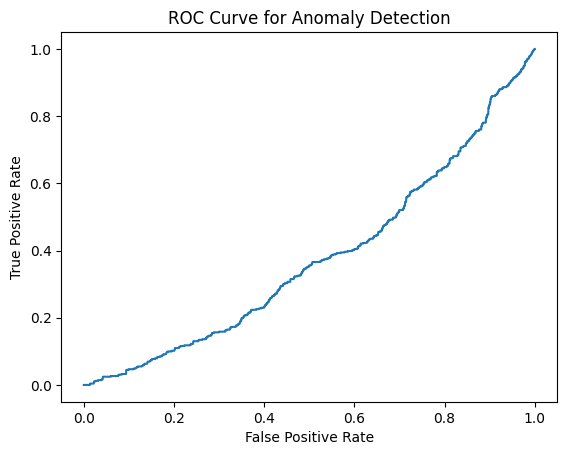

In [25]:
fpr, tpr, _ = roc_curve(data['Class'], best_model.decision_function(data[['scaled_amount', 'scaled_time']]))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.show()